In [1]:
import wandb
import pandas as pd
import numpy as np
import seaborn as sns

from rliable import library as rly
from rliable import metrics
from rliable import plot_utils


float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

_ = sns.set(style="darkgrid", palette="colorblind")

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style("white")

# Matplotlib params
from matplotlib import rcParams
from matplotlib import rc

rcParams['legend.loc'] = 'best'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

rc('text', usetex=False)

In [3]:
def set_axes(ax, xlim, ylim, xlabel, ylabel):
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  ax.set_xlabel(xlabel, labelpad=14)
  ax.set_ylabel(ylabel, labelpad=14)
 
def set_ticks(ax, xticks, xticklabels, yticks, yticklabels):
  ax.set_xticks(xticks)
  ax.set_xticklabels(xticklabels)
  ax.set_yticks(yticks)
  ax.set_yticklabels(yticklabels)

def decorate_axis(ax, wrect=10, hrect=10, labelsize='large'):
  # Hide the right and top spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_linewidth(2)
  ax.spines['bottom'].set_linewidth(2)
  # Deal with ticks and the blank space at the origin
  ax.tick_params(length=0.1, width=0.1, labelsize=labelsize)
  # Pablos' comment
  ax.spines['left'].set_position(('outward', hrect))
  ax.spines['bottom'].set_position(('outward', wrect))

In [4]:
entity = "a-jesson"
projects = {
    "PPO": {
        "starpilot": "ppo-3ow",
        "bossfight": "ppo-5bk",
        "fruitbot": "ppo-8z4",
        "miner": "ppo-4lu",
        "chaser": "ppo-am4",
        "leaper": "ppo-3m1",
        "plunder": "ppo-5iy",
        "ninja": "ppo-8kn",
        "coinrun": "ppo-8th",
        "caveflyer": "ppo-2gx",
        "jumper": "ppo-3qv",
        "climber": "ppo-1xr",
        "maze": "ppo-yae",
        "heist": "ppo-4tk",
        "dodgeball": "ppo-3jr",
        "bigfish": "ppo-5ew",
    },
    "VSOP": {
        "starpilot": "vsop-8c2",
        "bossfight": "vsop-n8n",
        "fruitbot": "vsop-276",
        "miner": "vsop-8pi",
        "chaser": "vsop-8pa",
        "leaper": "vsop-2at",
        "plunder": "vsop-41y",
        "ninja": "vsop-7td",
        "coinrun": "vsop-9ra",
        "caveflyer": "vsop-9aq",
        "jumper": "vsop-5f6",
        "climber": "vsop-60b",
        "maze": "vsop-4ow",
        "heist": "vsop-926",
        "dodgeball": "vsop-82s",
        "bigfish": "vsop-9q7",
    },
    "ICE-3D": {
        "starpilot": "ice-3d-baseline",
        "bossfight": "ice-3d-baseline",
        "fruitbot": "ice-3d-baseline",
        "miner": "ice-3d-baseline",
        "chaser": "ice-3d-baseline",
        "leaper": "ice-3d-baseline",
        "plunder": "ice-3d-baseline",
        "ninja": "ice-3d-baseline",
        "coinrun": "ice-3d-baseline",
        "caveflyer": "ice-3d-baseline",
        "jumper": "ice-3d-baseline",
        "climber": "ice-3d-baseline",
        "maze": "ice-3d-baseline",
        "heist": "ice-3d-baseline",
        "dodgeball": "ice-3d-baseline",
        "bigfish": "ice-3d-baseline",
    }
}

In [5]:
def get_last_avg_return(entity, projects, window=100):
    output = {}
    for method, mapping in projects.items():
        method_output = {}
        api = wandb.Api()
        for project, exp in mapping.items():
            runs = api.runs(entity + "/" + project)
            values = [0]*5
            for run in runs:
                _, experiment, seed, _ = run.name.split("__")
                if experiment == exp:
                    history = run.scan_history(keys=["test/episodic_return", "global_step"], min_step=run.lastHistoryStep - window)
                    df_ = pd.DataFrame(history)
                    values[int(seed)] = df_.loc[-window:, "test/episodic_return"].mean()
            method_output.update({project: values})
        output.update({method: method_output})
    return output

In [6]:
procgen_data_dict = get_last_avg_return(entity, projects)

In [7]:
EASY_GAME_RANGES = {
    'coinrun': [5, 10],
    'starpilot': [2.5, 64],
    'caveflyer': [3.5, 12],
    'dodgeball': [1.5, 19],
    'fruitbot': [-1.5, 32.4],
    'chaser': [.5, 13],
    'miner': [1.5, 13],
    'jumper': [1, 10],
    'leaper': [1.5, 10],
    'maze': [5, 10],
    'bigfish': [1, 40],
    'heist': [3.5, 10],
    'climber': [2, 12.6],
    'plunder': [4.5, 30],
    'ninja': [3.5, 10],
    'bossfight': [.5, 13],
}

PROCGEN_ENVS = [
 'bigfish',
 'bossfight',
 'caveflyer',
 'chaser',
 'climber',
 'coinrun',
 'dodgeball',
 'fruitbot',
 'heist',
 'jumper',
 'leaper',
 'maze',
 'miner',
 'ninja',
 'plunder',
 'starpilot'
]

def score_normalization_procgen(res_dict, min_scores, max_scores):
  games = res_dict.keys()
  norm_scores = {}
  for game, scores in res_dict.items():
    norm_scores[game] = (np.array(scores) - min_scores[game])/(max_scores[game] - min_scores[game])
  return norm_scores

MIN_PROCGEN_SCORES = {g: EASY_GAME_RANGES[g][0] for g in PROCGEN_ENVS}
MAX_PROCGEN_SCORES = {g: EASY_GAME_RANGES[g][1] for g in PROCGEN_ENVS}

min_max_procgen_normalize = lambda scores: score_normalization_procgen(
    scores, MIN_PROCGEN_SCORES, MAX_PROCGEN_SCORES)

In [8]:
def pgs(f):
  print(inspect.getsource(f))

def score_normalization(res_dict, min_scores, max_scores):
  games = res_dict.keys()
  norm_scores = {}
  for game, scores in res_dict.items():
    norm_scores[game] = (scores - min_scores[game])/(max_scores[game] - min_scores[game])
  return norm_scores


def convert_to_matrix(score_dict):
   keys = sorted(list(score_dict.keys()))
   return np.stack([score_dict[k] for k in keys], axis=1)

def plot_score_hist(score_matrix, bins=20, figsize=(28, 14), 
                    fontsize='xx-large', N=6, extra_row=1,
                    names=None):
  num_tasks = score_matrix.shape[1]
  if names is None:
    names = ATARI_100K_GAMES
  N1 = (num_tasks // N) + extra_row
  fig, ax = plt.subplots(nrows=N1, ncols=N, figsize=figsize)
  for i in range(N):
    for j in range(N1):
      idx = j * N + i
      if idx < num_tasks:
        ax[j, i].set_title(names[idx], fontsize=fontsize)
        sns.histplot(score_matrix[:, idx], bins=bins, ax=ax[j,i], kde=True)
      else:
        ax[j, i].axis('off')
      decorate_axis(ax[j, i], wrect=5, hrect=5, labelsize='xx-large')
      ax[j, i].xaxis.set_major_locator(plt.MaxNLocator(4))
      if idx % N == 0:
        ax[j, i].set_ylabel('Count', size=fontsize)
      else:
        ax[j, i].yaxis.label.set_visible(False)
      ax[j, i].grid(axis='y', alpha=0.1)
  return fig

In [9]:
IQM = lambda x: metrics.aggregate_iqm(x) # Interquartile Mean
OG = lambda x: metrics.aggregate_optimality_gap(x, 1.0) # Optimality Gap
MEAN = lambda x: metrics.aggregate_mean(x)
MEDIAN = lambda x: metrics.aggregate_median(x)

In [10]:
# Create PPO Normalization
MEAN_PPO_SCORES = {key: np.mean(val) for key, val in procgen_data_dict['PPO'].items()}
ZERO_SCORES = {key: 0.0 for key in PROCGEN_ENVS}
ppo_procgen_normalize = lambda scores: score_normalization_procgen(
    scores, ZERO_SCORES, MEAN_PPO_SCORES)

norm_procgen_data = {'Min-Max': {}, 'PPO': {}}
algorithms = ['PPO', 'VSOP', "ICE-3D"]
for method in algorithms:
  scores = procgen_data_dict[method]
  norm_procgen_data['Min-Max'][method] = convert_to_matrix(
      min_max_procgen_normalize(scores))
  norm_procgen_data['PPO'][method] = convert_to_matrix(
      ppo_procgen_normalize(scores))

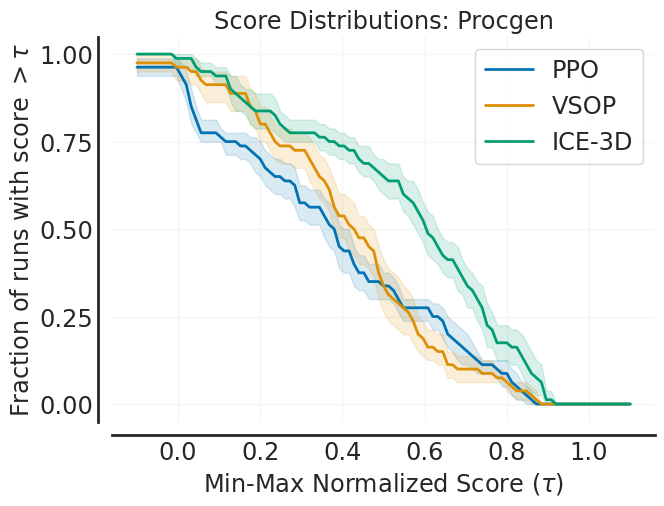

In [11]:
procgen_tau = np.linspace(-0.1, 1.1, 101)
procgen_profiles, procgen_profile_cis = rly.create_performance_profile(
    norm_procgen_data['Min-Max'], procgen_tau, reps=2000)


fig, ax = plt.subplots(figsize=(7, 5))
algorithms = ['PPO', 'VSOP', "ICE-3D"]
plot_utils.plot_performance_profiles(
  procgen_profiles, procgen_tau,
  performance_profile_cis=procgen_profile_cis,  
  xlabel=r'Min-Max Normalized Score $(\tau)$',
  legend=True, ax=ax)
ax.set_title('Score Distributions: Procgen', size='x-large')
plt.show()

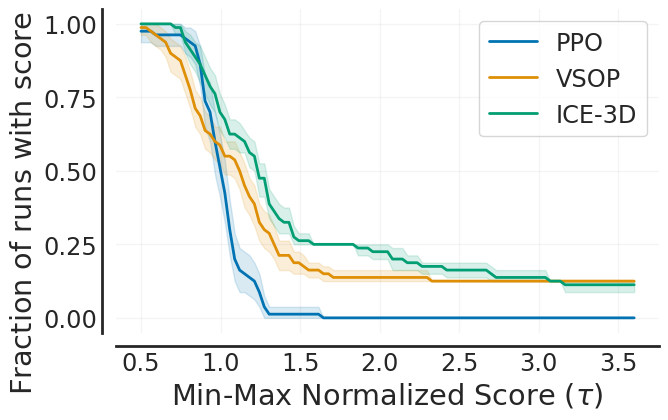

In [12]:
procgen_tau = np.linspace(0.5, 3.6, 101)
procgen_profiles, procgen_profile_cis = rly.create_performance_profile(
    norm_procgen_data['PPO'], procgen_tau, reps=2000)


fig, ax = plt.subplots(figsize=(7, 4.2))
plot_utils.plot_performance_profiles(
  procgen_profiles, procgen_tau,
  performance_profile_cis=procgen_profile_cis,  
  xlabel=r'Min-Max Normalized Score $(\tau)$',
  labelsize='xx-large',
  legend=True, ax=ax)
# ax.set_title('Score Distributions: Procgen', size='x-large')
plt.show()

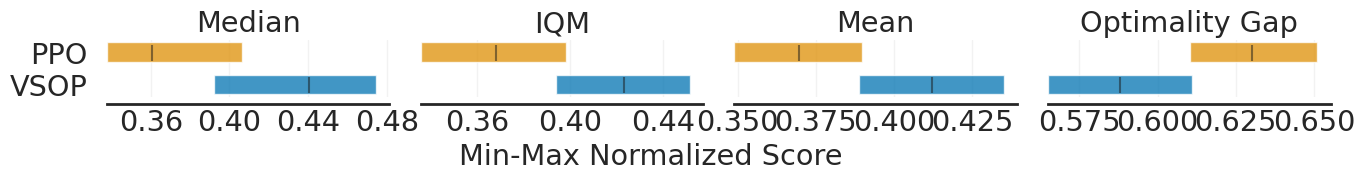

In [12]:
procgen_scores = norm_procgen_data['Min-Max']
aggregate_func = lambda x: np.array([MEDIAN(x), IQM(x), MEAN(x), OG(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
    procgen_scores, aggregate_func, reps=50000)


algorithms = ['VSOP', 'PPO']
fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, 
    aggregate_interval_estimates,
    metric_names = ['Median', 'IQM', 'Mean', 'Optimality Gap'],
    algorithms=algorithms,
    xlabel_y_coordinate=-0.8,
    xlabel='Min-Max Normalized Score')

plt.show()

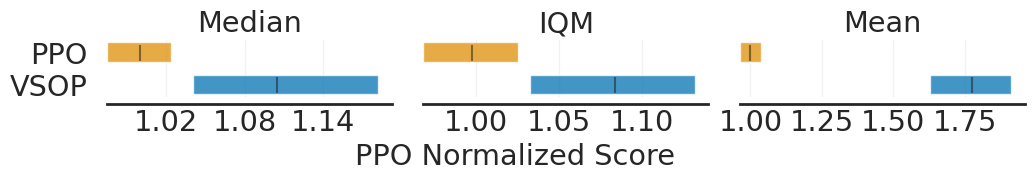

In [13]:
procgen_ppo_scores = norm_procgen_data['PPO']
aggregate_func = lambda x: np.array([MEDIAN(x), IQM(x), MEAN(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
    procgen_ppo_scores, aggregate_func, reps=50000)


algorithms = ['VSOP', 'PPO']
fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, 
    aggregate_interval_estimates,
    metric_names = ['Median', 'IQM', 'Mean'],
    algorithms=algorithms,
    xlabel_y_coordinate=-0.8,
    xlabel='PPO Normalized Score')

plt.show()

In [20]:
pairs = [['VSOP', 'PPO'], ['ICE-3D', 'PPO'], ['ICE-3D', 'VSOP']]

procgen_algorithm_pairs = {}
for pair in pairs[::-1]:
  d1 = norm_procgen_data['Min-Max'][pair[0]]
  d2 = norm_procgen_data['Min-Max'][pair[1]]
  # d_concat = np.concatenate((d1, d2), axis=-1)
  procgen_algorithm_pairs['_'.join(pair)] = (d1, d2)

probabilities, probability_cis = rly.get_interval_estimates(
    procgen_algorithm_pairs, metrics.probability_of_improvement, reps=2000)

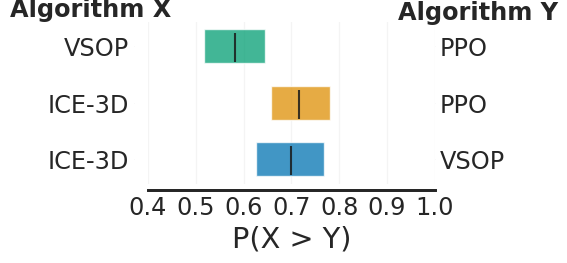

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.7, 2.1))
h = 0.6

ax2 = ax.twinx()
colors = sns.color_palette('colorblind')

for i, (pair, p) in enumerate(probabilities.items()):  
  (l, u), p  = probability_cis[pair], p

  ax.barh(y=i, width=u-l, height=h, 
          left=l, color=colors[i], 
          alpha=0.75, label=pair[0])
  ax2.barh(y=i, width=u-l, height=h, 
          left=l, color=colors[i], 
          alpha=0.0, label=pair[1])
  ax.vlines(x=p, ymin=i-7.5 * h/16, ymax=i+(6*h/16),
            color='k', alpha=0.85)
  

ax.set_yticks(list(range(len(pairs))))
ax2.set_yticks(range(len(pairs)))
pairs = [x.split('_') for x in probabilities.keys()]
ax2.set_yticklabels([pair[1] for pair in pairs], fontsize='large')
ax.set_yticklabels([pair[0] for pair in pairs], fontsize='large')
ax2.set_ylabel('Algorithm Y', fontweight='bold', rotation='horizontal', fontsize='x-large')
ax.set_ylabel('Algorithm X', fontweight='bold', rotation='horizontal', fontsize='x-large')
ax.set_xticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.yaxis.set_label_coords(-0.2, 1.0)
ax2.yaxis.set_label_coords(1.15, 1.13)
decorate_axis(ax, wrect=5)
decorate_axis(ax2, wrect=5)
       
ax.tick_params(axis='both', which='major', labelsize='x-large')
ax2.tick_params(axis='both', which='major', labelsize='x-large')
ax.set_xlabel('P(X > Y)', fontsize='xx-large')
ax.grid(axis='x', alpha=0.2)
plt.subplots_adjust(wspace=0.05)
ax.spines['left'].set_visible(False)
ax2.spines['left'].set_visible(False)


plt.show()